# Toy Diffusion

This first implementation of our diffusion model will try to generate 2D shapes.

Inspired of this repository and project : https://github.com/ThiagoLira/ToyDiffusion

In [1]:
import torch
import math
import numpy as np
from diffusion import noise_x_t, noise_x_t_with_t_minus_1
from utils import pack_data, unpack_1d_data, scatter_pixels

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


/home/r-one/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### Dataset used

We will try to generate a '6' from the mnist dataset converted in 2D.

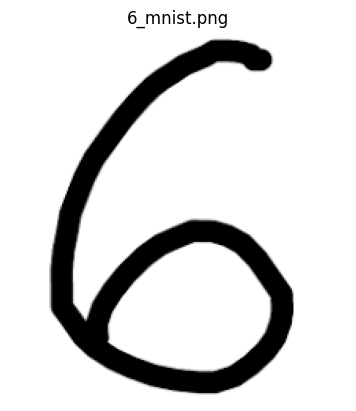

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "datasets/2D_ToyDiffusion_data/6_mnist.png"
img = Image.open(img_path)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("6_mnist.png")
plt.show()

In [3]:
x,y = scatter_pixels('datasets/2D_ToyDiffusion_data/6_mnist.png')
x = [x/25 -3 for x in x]
y = [y/25 -2 for y in y]

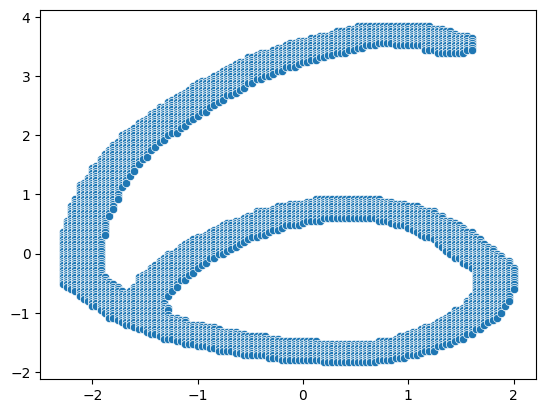

In [4]:
import seaborn as sns
ax = sns.scatterplot(x=x, y=y)

## Store the ax to plot the result later
y_ax = ax.get_ylim()
x_ax = ax.get_xlim()
axes = (x_ax,y_ax)

# send data to device
one_d_data = pack_data(x,y)
x_init = torch.tensor(one_d_data).to(torch.float32).to(device)

DATA_SIZE = len(x_init)


# Noising Exemple Phase

In [5]:
T = 50
sigma_list = torch.linspace(1, 0, steps=T).to(device)
print(sigma_list)
print(len(sigma_list))

tensor([1.0000, 0.9796, 0.9592, 0.9388, 0.9184, 0.8980, 0.8776, 0.8571, 0.8367,
        0.8163, 0.7959, 0.7755, 0.7551, 0.7347, 0.7143, 0.6939, 0.6735, 0.6531,
        0.6327, 0.6122, 0.5918, 0.5714, 0.5510, 0.5306, 0.5102, 0.4898, 0.4694,
        0.4490, 0.4286, 0.4082, 0.3878, 0.3673, 0.3469, 0.3265, 0.3061, 0.2857,
        0.2653, 0.2449, 0.2245, 0.2041, 0.1837, 0.1633, 0.1429, 0.1224, 0.1020,
        0.0816, 0.0612, 0.0408, 0.0204, 0.0000])
50


Création du GIF en cours...


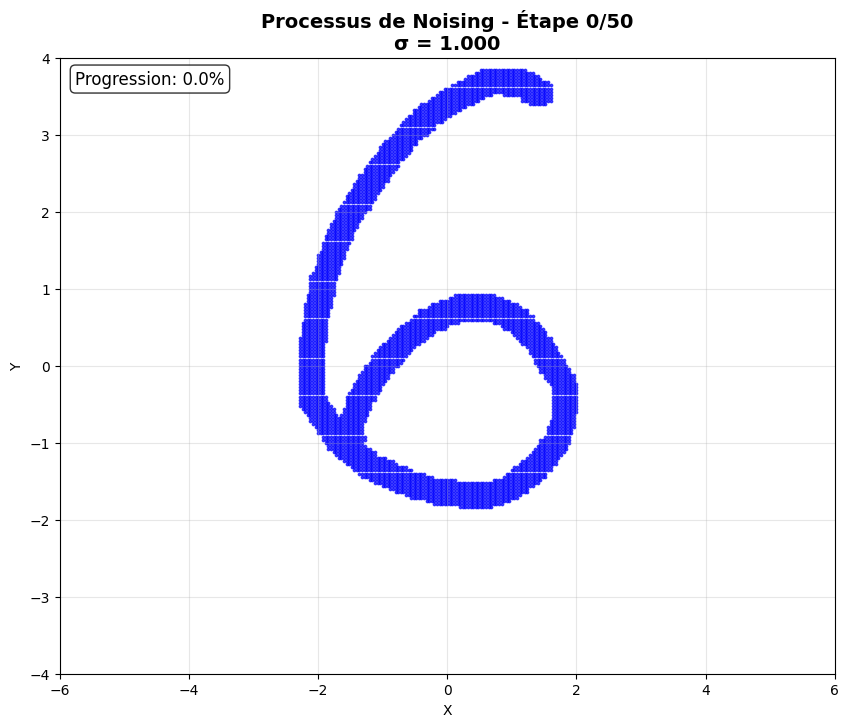

In [6]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

def create_noising_gif():
    fig, ax = plt.subplots(figsize=(10, 8))
    
    def animate(frame):
        ax.clear()
        t = frame
        if t < T:
            noisy_data = noise_x_t_with_t_minus_1(x_init, t, sigma_list)
            x_noisy = noisy_data[0::2].cpu().numpy()
            y_noisy = noisy_data[1::2].cpu().numpy()
            
            ax.scatter(x_noisy, y_noisy, s=3, color='blue', alpha=0.7)
            ax.set_xlim(-6, 6)
            ax.set_ylim(-4, 4)
            sigma_val = sigma_list[t] if t < len(sigma_list) else sigma_list[-1]
            ax.set_title(f'Processus de Noising - Étape {t}/{T}\nσ = {sigma_val:.3f}', 
                        fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            
            progress = t / T
            ax.text(0.02, 0.98, f'Progression: {progress:.1%}', 
                   transform=ax.transAxes, fontsize=12, 
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    anim = animation.FuncAnimation(fig, animate, frames=T+1, interval=200, repeat=True)
    
    print("Création du GIF en cours...")
    writer = PillowWriter(fps=5)
    anim.save('diffusion_noising_process.gif', writer=writer)    
    return anim

anim = create_noising_gif()

# Training Phase

# Generation Phase